In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import qutip

In [2]:
dev = qml.device('lightning.qubit', wires=3)

In [3]:
N = 400

In [4]:
data = np.random.normal(loc=0,scale=1.5, size=N)

In [5]:
data = data/np.max(np.abs(data))

In [6]:
values, counts = np.histogram(data)

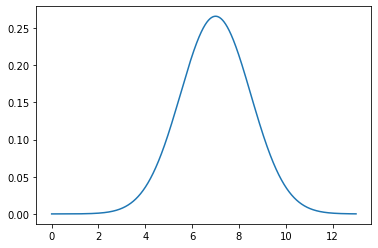

In [7]:
from scipy.stats import norm
x_axis = np.arange(0, 13, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,7,1.5))
plt.show()


Text(0.5, 0, 'i')

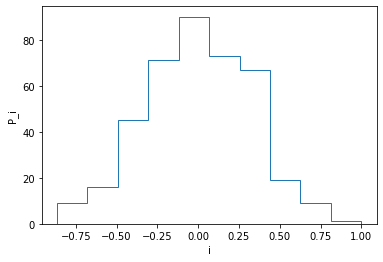

In [8]:
plt.hist(data, histtype='step')#, 'b.', markersize=12)
plt.ylabel('P_i')
plt.xlabel('i')

In [9]:
data = (data+1)*np.pi/2

Text(0.5, 0, 'i')

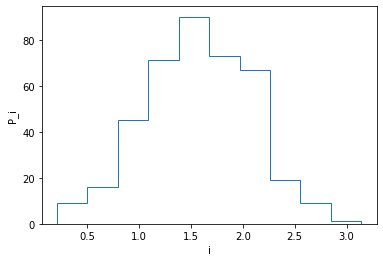

In [10]:
plt.hist(data, histtype='step')#, 'b.', markersize=12)
plt.ylabel('P_i')
plt.xlabel('i')

In [11]:
data_dev = qml.device('lightning.qubit', wires=1)

In [12]:
@qml.qnode(data_dev)
def data_dev_circ(data):
    qml.RY(data, wires=0)
    return qml.expval(qml.PauliZ(0))

(array([ 3., 13.,  6., 17., 25., 30., 27., 18., 30., 20., 39., 31., 28.,
        27., 20., 18., 23., 10.,  6.,  9.]),
 tensor([-1.        , -0.90111869, -0.80223738, -0.70335608, -0.60447477,
         -0.50559346, -0.40671215, -0.30783085, -0.20894954, -0.11006823,
         -0.01118692,  0.08769438,  0.18657569,  0.285457  ,  0.38433831,
          0.48321961,  0.58210092,  0.68098223,  0.77986354,  0.87874484,
          0.97762615], requires_grad=True),
 <BarContainer object of 20 artists>)

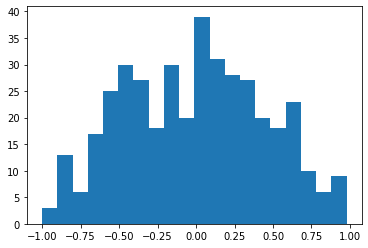

In [13]:
plt.hist(data_dev_circ(data), bins=20)

In [14]:
def G_anastz(z, params):
    layers = int(len(params)/2)
    #qml.Rot(params[0], params[1], params[2], wires=0)
    for i in range(layers): qml.RY(params[i]*z + params[i+layers], wires=0)

In [14]:
@qml.qnode(dev)
def circuit2(z, params):
    G_anastz(z, params)
    return qml.expval(qml.PauliZ(0))

In [15]:
fig, ax = qml.draw_mpl(circuit2)(0.5,np.zeros(shape=8,))
fig.show()

NameError: name 'G_anastz' is not defined

## normal swap

In [17]:
@qml.qnode(dev)
def training_circ(z, paramsg, data):
    # top 4 qbits real data
    qml.RY(data, wires=1)
    # bottom 4 qbits gen ansatz
    G_anastz(z, paramsg)
    
    #eps = 0.2
    #noise = np.random.uniform(-eps,eps)
    #qml.RY(noise, wires=0)
    #noise = np.random.uniform(-eps,eps)
    #qml.RY(noise, wires=1)
    
    qml.Hadamard(wires=2)
    qml.CSWAP(wires=[2,0,1])
    qml.Hadamard(wires=2)
    return qml.expval(qml.PauliZ(2))

/tmp/ipykernel_2074331/2437749077.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


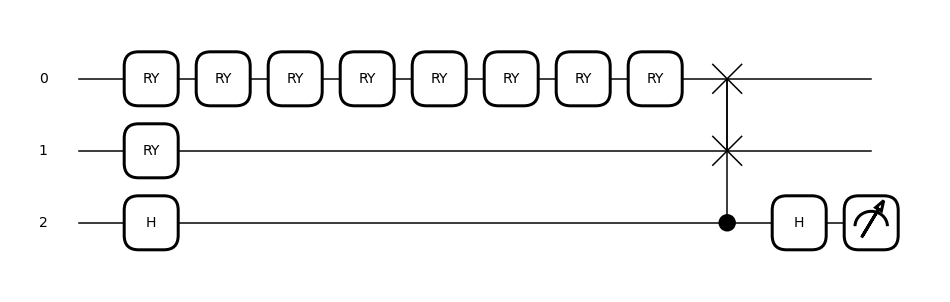

In [18]:
fig, ax = qml.draw_mpl(training_circ)(0.5,np.random.random(size=(16,)), 0.5)
fig.show()

## Training 

In [19]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]
        
def cost_batch_old(paramsg, paramsd, batch):
    loss = 0.0
    for i in batch:
        f = training_circ(i, paramsg, paramsd)
        loss = loss + np.log(1 - f)
    return loss / len(batch)

def cost_batch(paramsg, batch, reg=0.000001):
    lam = 0.05
    loss = 0.0
    for i in batch:
        z = np.random.normal(-1, 1, requires_grad=False)
        f = training_circ(z, paramsg, i) + reg
        loss += - f + lam*np.sum(np.abs(paramsg))
    return loss / len(batch)

In [20]:
paramsg = np.random.normal(0,1, size=(40,), requires_grad=True)

In [21]:
epochs = 200
batch_size=16
learning_rate=0.002

In [22]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

In [23]:
@qml.qnode(dev)
def sample_test_b(z):
    G_anastz(z, paramsg)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]

b = qutip.Bloch()

def plot_bloch_sample():
    pnts = []
    for i in range(N):
        z = np.random.uniform(-1,1)
        vs = sample_test_b(z)
        pnts += [vs]
    pnts = np.array(pnts)
    b.clear()
    b.add_points([pnts[:,0],pnts[:,1],pnts[:,2]])
    b.save(dirc='imgs') 
    #b.show()

In [24]:
print("initial paramsg:", paramsg)

paramsg_before = paramsg.copy()

losshist = []

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=batch_size)):  
        cost_fn = lambda p: cost_batch(p, Xbatch)
        paramsg = optg.step(cost_fn, paramsg)
        plot_bloch_sample()
        print(j, end="\r")
        #if j % 20 == 0:
        #    loss = cost_batch(params,Xbatch)
        #    print(f"Step: {j} | Loss: {loss:.3} |")
    
    loss = cost_batch(paramsg, data)
    
    losshist += [loss]
    
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | ")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

print("final paramsg:", paramsg)

initial paramsg: [-0.31636583  0.50556574 -1.8333305   0.11542149 -2.35757732  0.45733755
  1.13966367 -0.82049201 -1.03715095 -0.54388251 -1.13682701  0.55779325
 -1.01518442  0.13485794  0.4063964   1.2678984   0.98609875 -0.13460934
 -1.17690368 -1.79631745 -0.92629377 -0.43462055  1.37461303  0.69911692
 -0.46724444 -0.5070412  -0.44464593  0.31677287 -1.57393307 -2.46499434
 -1.2885992  -1.11370092 -1.57056149 -0.49305537 -0.4019278   1.07301075
  1.61883255  0.38712368 -0.90870338  0.868163  ]
____
Epoch: 0 | Loss: 1.28 | 
____
____
Epoch: 1 | Loss: 1.22 | 
____
____
Epoch: 2 | Loss: 1.17 | 
____
____
Epoch: 3 | Loss: 1.13 | 
____
____
Epoch: 4 | Loss: 1.1 | 
____
____
Epoch: 5 | Loss: 1.06 | 
____
____
Epoch: 6 | Loss: 1.0 | 
____
____
Epoch: 7 | Loss: 0.984 | 
____
____
Epoch: 8 | Loss: 0.929 | 
____
____
Epoch: 9 | Loss: 0.86 | 
____
____
Epoch: 10 | Loss: 0.865 | 
____
____
Epoch: 11 | Loss: 0.788 | 
____
____
Epoch: 12 | Loss: 0.75 | 
____
____
Epoch: 13 | Loss: 0.735 | 
___


KeyboardInterrupt



Text(0, 0.5, 'loss')

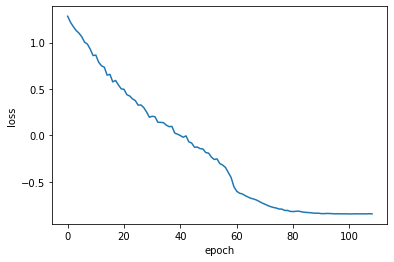

In [25]:
plt.plot(losshist)
plt.xlabel("epoch")
plt.ylabel("loss")

In [26]:
@qml.qnode(dev)
def sample_test(z):
    G_anastz(z, paramsg)
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_2074331/1079402710.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


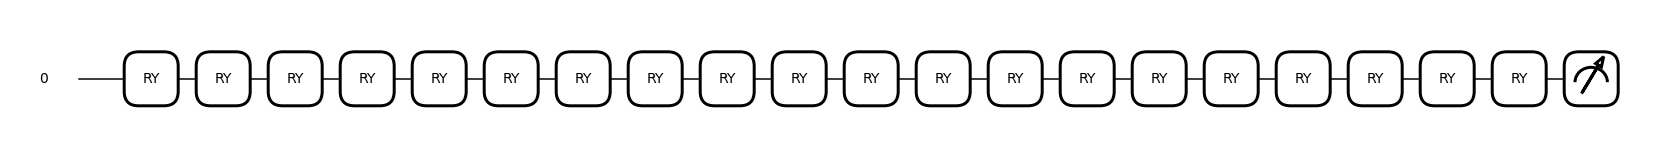

In [27]:
fig, ax = qml.draw_mpl(sample_test)(0.5)
fig.show()

In [28]:
testresult = []
for i in range(N):
    z = np.random.uniform(-1,1)
    testresult += [sample_test(z)]

(array([51., 33., 35., 41., 40., 53., 46., 33., 35., 33.]),
 array([0.1125126 , 0.11765399, 0.12279537, 0.12793675, 0.13307813,
        0.13821952, 0.1433609 , 0.14850228, 0.15364367, 0.15878505,
        0.16392643]),
 <BarContainer object of 10 artists>)

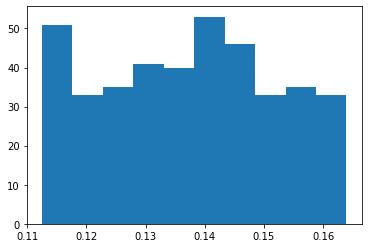

In [29]:
plt.hist(testresult)